In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
taggram = np.load("../preprocessing/MusicnnFeatures/taggram_array.npy")

In [4]:
print(np.shape(taggram))

(400, 20, 50)


In [5]:
label_songs = pd.read_csv("../preprocessing/labels.csv")
info_songs = pd.read_csv("../data/Info/info.csv")

labels = label_songs["genre"].map({"classical":0, "electronic":1, "pop":2, "rock":3})
labels = labels.to_numpy()

In [6]:
n_data = len(label_songs)
idx = np.random.permutation(n_data)
info_songs = info_songs.reindex(idx)
taggram = taggram[idx, :, :]
labels = labels[idx]

taggram_raw = taggram[:]
labels_raw = labels[:]

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

sample_size = (5, 50)

drop_out_rate = 0.2

# very simple keras Sequential model
input_tensor = Input(sample_size)
x = layers.Dense(50, activation="relu")(input_tensor)
x = layers.Flatten()(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(4, activation="softmax")(x)

model_1 = tf.keras.Model(input_tensor, output_tensor)

In [8]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 50)]           0         
_________________________________________________________________
dense (Dense)                (None, 5, 50)             2550      
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1004      
Total params: 3,554
Trainable params: 3,554
Non-trainable params: 0
_________________________________________________________________


In [9]:
def slice_accordingly(input_tensor, labels, size=5):

    input_shape = (tf.shape(input_tensor).numpy())
    
    input_shape[1] = size
    size = input_shape
    
    sliced_tensor = tf.image.random_crop(input_tensor, size)
    
    nan_values, idx = tf.unique(tf.gather(tf.where(tf.math.is_nan(sliced_tensor)), 0, axis=1))
    nan_values = nan_values.numpy()
  
    msk = np.zeros((input_shape[0]), dtype=np.bool)
    msk[nan_values] = True
    msk = ~msk

    sliced_tensor = tf.boolean_mask(sliced_tensor, msk , axis=0)
    labels = tf.boolean_mask(labels , msk, axis=0)
    
    return sliced_tensor, labels

In [10]:
fraction_validation = 0.5
n_test = int(fraction_validation*len(labels))
n_train = len(labels) - n_test

train_features, train_labels = taggram[:n_train], labels[:n_train]
validation_features, validation_labels = taggram[n_train:], labels[n_train:]

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))

In [12]:
model = model_1

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

n_epochs = 100
batch_size = 50

history_df = pd.DataFrame()

for epoch in range(n_epochs):
    print("Epoch", epoch)
    train_ds = train_dataset.shuffle(n_train).batch(batch_size)
    val_ds = validation_dataset.shuffle(n_test).batch(n_test)
    
    x_val, y_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)
    
    for features, labels in train_ds:
        features, labels = slice_accordingly(features, labels)
        
        history = model.fit(features, labels,
                           validation_data=(x_val, y_val),
                           verbose=1) 
        
                
        history = pd.DataFrame(history.history)
        history_df = history_df.append(history)

Epoch 0
2/2 [==============================] - 0s 83ms/step - loss: 1.3404 - accuracy: 0.3800 - val_loss: 1.3215 - val_accuracy: 0.3788
Epoch 1
2/2 [==============================] - 0s 67ms/step - loss: 1.2783 - accuracy: 0.4600 - val_loss: 1.2611 - val_accuracy: 0.5829
Epoch 2
2/2 [==============================] - 0s 68ms/step - loss: 1.2115 - accuracy: 0.7000 - val_loss: 1.2322 - val_accuracy: 0.6550
Epoch 3
2/2 [==============================] - 0s 67ms/step - loss: 1.1498 - accuracy: 0.6800 - val_loss: 1.1275 - val_accuracy: 0.7121
Epoch 4
2/2 [==============================] - 0s 72ms/step - loss: 0.9913 - accuracy: 0.8000 - val_loss: 1.0727 - val_accuracy: 0.7186
Epoch 5
2/2 [==============================] - 0s 83ms/step - loss: 0.9648 - accuracy: 0.6800 - val_loss: 0.9839 - val_accuracy: 0.7020
Epoch 6
2/2 [==============================] - 0s 81ms/step - loss: 0.8405 - accuracy: 0.6939 - val_loss: 0.9917 - val_accuracy: 0.6600
Epoch 7
2/2 [==============================] - 0

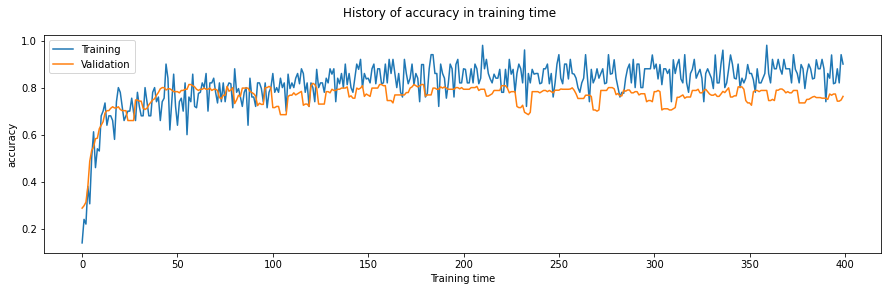

In [13]:
%matplotlib inline

metric = "accuracy" #Choose between 'loss', 'MSE', 'cosine similarity', 'r2'

import matplotlib.pyplot as plt
try: history_df = history_df.reset_index()
except: pass

metrics_dict = {"loss": ["loss", "val_loss"], "accuracy": ["accuracy", "val_accuracy"]}

fig, ax = plt.subplots(figsize=(15,4),nrows=1, ncols=1)
ax.set_ylabel(f"{metric}")
ax.set_xlabel("Training time")
fig.suptitle(f"History of {metric} in training time")

train_plot = history_df.plot(y=metrics_dict[metric][0], use_index=True, ax=ax, label="Training")
val_plot = history_df.plot(y=metrics_dict[metric][1], use_index=True, ax=ax, label="Validation")

plt.show()

# "Cross-validation"

In [14]:
from sklearn.model_selection import KFold


n_splits = 5
kf = KFold(n_splits=n_splits)

predictions_and_labels = {}

count = 0


for train_index, test_index in kf.split(taggram_raw):
    
    print(f"Training K-fold {1+count} of {n_splits}")

    train_features, train_labels = taggram_raw[train_index], labels_raw[train_index]
    validation_features, validation_labels = taggram_raw[test_index], labels_raw[test_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))
    
    sample_size = (5, 50)

    drop_out_rate = 0.2

    # very simple keras Sequential model
    input_tensor = Input(sample_size)
    x = layers.Dense(50, activation="relu")(input_tensor)
    x = layers.Flatten()(x)
    x = layers.Dropout(drop_out_rate)(x)
    output_tensor = layers.Dense(4, activation="softmax")(x)
    
    model = tf.keras.Model(input_tensor, output_tensor)

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    n_epochs = 100
    batch_size = 50
    
    for epoch in range(n_epochs):
        train_ds = train_dataset.shuffle(n_train).batch(batch_size)
        for features, labels in train_ds:
            features, labels = slice_accordingly(features, labels)
            model.fit(features, labels, verbose=0)
            
    x_val, y_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)
    
    pred_ = model.predict(x_val)
    
    predictions_and_labels[count] = [pred_, y_val]
    count = count+1

Training K-fold 1 of 5
Training K-fold 2 of 5
Training K-fold 3 of 5
Training K-fold 4 of 5
Training K-fold 5 of 5


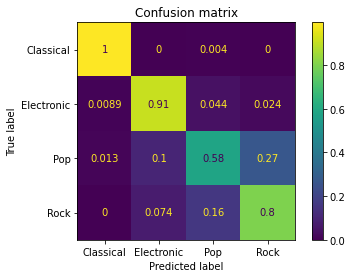

The accuracy is approximately: 81.59 +- 2.06%


In [21]:
%matplotlib inline

import IPython
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = np.zeros((4,4))
accuracies = []

for i in range(max(predictions_and_labels.keys())+1):
    y_pred = predictions_and_labels[i][0]
    y_pred = tf.argmax(y_pred,1)
    y_true = predictions_and_labels[i][1]
    
    conf_mat = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    
    accuracies.append(np.sum(np.eye(4)*conf_mat)/np.sum(conf_mat))
    
    cm += conf_mat

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = cm / cm.astype(np.float).sum(axis=1)

ls = ["Classical", "Electronic", "Pop", "Rock"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot(include_values=True, colorbar=True, cmap="viridis")
plt.title("Confusion matrix")
plt.show()

print(f'The accuracy is approximately: {100*np.mean(100*accuracies):.2f} +- {100*np.std(accuracies):.2f}%')